Extreme AQI Prediction using Extreme Value Theorm

In [2]:
# Starting Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,r2_score,roc_auc_score,roc_curve,f1_score,mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from scipy.stats import genextreme
from pyextremes import EVA

## Loading Data and Basic EDA

In [ ]:
# Read in dataset from local file folder
df = pd.read_excel('Final_Dataset_Working_File.xlsx')

# Some basic data exploration
print("Shape of df: ", df.shape)
print("Columns: ",df.columns.tolist())
print("Data Types: ",df.dtypes)
display(df.head())

Shape of df:  (6574, 12)
Columns:  ['Date', 'AQI Value', 'AQI Class', 'CO Value', 'Ozone Value', 'NO2 Value', 'PM 2.5 Value', 'PM 10 Value', 'SO2 Value', 'Pressure Value', 'Temperature Value', 'Wind Value']
Data Types:  Date                 datetime64[ns]
AQI Value                     int64
AQI Class                    object
CO Value                    float64
Ozone Value                 float64
NO2 Value                   float64
PM 2.5 Value                float64
PM 10 Value                 float64
SO2 Value                   float64
Pressure Value              float64
Temperature Value           float64
Wind Value                  float64
dtype: object


,Date,AQI Value,AQI Class,CO Value,Ozone Value,NO2 Value,PM 2.5 Value,PM 10 Value,SO2 Value,Pressure Value,Temperature Value,Wind Value
0,2006-01-01,66,NaN,0.610143,0.006471,12.652174,14.500000,NaN,3.270834,1019.375000,41.416666,129.675000
1,2006-01-02,86,NaN,0.812500,0.003765,13.391304,18.055556,NaN,4.981250,1019.208333,37.937500,39.867708
2,2006-01-03,41,NaN,0.504167,0.010353,12.293996,4.566667,NaN,0.908334,1011.750000,41.708334,48.482292
3,2006-01-04,67,NaN,0.432440,0.012529,14.739130,14.900000,NaN,3.572916,1015.583333,39.833334,88.468750
4,2006-01-05,56,NaN,0.251041,0.007471,15.014492,10.430000,15.666667,3.645834,1008.083333,44.750000,143.254167


In [4]:
# More data exploration
print("Summary Stats: ")
display(df.describe())

print('Num of missing values per col: ')
display(df.isnull().sum())

Summary Stats: 


,Date,AQI Value,CO Value,Ozone Value,NO2 Value,PM 2.5 Value,PM 10 Value,SO2 Value,Pressure Value,Temperature Value,Wind Value
count,6574,6574.000000,6568.000000,6502.000000,6557.000000,6511.000000,1131.000000,6476.000000,6363.000000,6564.000000,6564.000000
mean,2014-12-31 12:00:00.000000256,60.415729,0.313344,0.029141,14.258416,10.040188,14.962717,1.662865,1008.173544,55.641243,98.650457
min,2006-01-01 00:00:00,17.000000,0.000000,0.000000,1.854167,-1.225000,0.000000,-0.459661,981.287037,7.302083,20.819444
25%,2010-07-02 06:00:00,45.000000,0.202514,0.020059,9.709157,5.933499,9.000000,0.453843,1002.694568,41.882986,76.447135
50%,2014-12-31 12:00:00,55.000000,0.261793,0.029471,13.083333,8.612500,13.333333,1.064900,1007.511905,56.450339,99.169740
75%,2019-07-01 18:00:00,67.000000,0.372022,0.037954,17.522917,12.605833,18.500000,2.057292,1013.093013,70.551823,121.275036
max,2023-12-31 00:00:00,214.000000,1.876132,0.079193,44.730163,111.444444,93.333333,32.608442,1039.541667,88.520833,174.676389
std,NaN,24.990894,0.172874,0.012261,6.233658,6.197657,8.820443,1.932884,8.042275,16.538867,30.580161


Num of missing values per col: 


Date                    0
AQI Value               0
AQI Class            4749
CO Value                6
Ozone Value            72
NO2 Value              17
PM 2.5 Value           63
PM 10 Value          5443
SO2 Value              98
Pressure Value        211
Temperature Value      10
Wind Value             10
dtype: int64

In [5]:
# We want to fill missing columns, looks like PM10 is missing a
# great number of values, may want to consider dropping it as a feature later on
for col in df.select_dtypes(include=[float,int]).columns:
    df[col] = df[col].interpolate(method='linear')

df['PM 10 Value'] = df['PM 10 Value'].bfill()

print('Num of missing values per col after interpolation: ')
display(df.isnull().sum())

Num of missing values per col after interpolation: 


Date                    0
AQI Value               0
AQI Class            4749
CO Value                0
Ozone Value             0
NO2 Value               0
PM 2.5 Value            0
PM 10 Value             0
SO2 Value               0
Pressure Value          0
Temperature Value       0
Wind Value              0
dtype: int64

In [6]:
# Get the Pearson correlation values
cor_matrix = df.corr(numeric_only=True)

print("Pearson Correlation Matrix: ")
display(cor_matrix)

Pearson Correlation Matrix: 


,AQI Value,CO Value,Ozone Value,NO2 Value,PM 2.5 Value,PM 10 Value,SO2 Value,Pressure Value,Temperature Value,Wind Value
AQI Value,1.000000,0.300070,0.443898,0.344107,0.730262,0.417485,0.331879,0.117348,0.366473,-0.087016
CO Value,0.300070,1.000000,-0.306466,0.652616,0.523842,0.335102,0.484529,0.418084,-0.179326,-0.092683
Ozone Value,0.443898,-0.306466,1.000000,-0.312079,0.058966,0.151712,-0.060259,-0.165977,0.566573,0.015487
NO2 Value,0.344107,0.652616,-0.312079,1.000000,0.529000,0.226690,0.412118,0.306946,-0.256985,-0.139495
PM 2.5 Value,0.730262,0.523842,0.058966,0.529000,1.000000,0.467737,0.440762,0.192685,0.102354,-0.124574
PM 10 Value,0.417485,0.335102,0.151712,0.226690,0.467737,1.000000,0.389101,0.278501,0.155909,-0.033164
SO2 Value,0.331879,0.484529,-0.060259,0.412118,0.440762,0.389101,1.000000,0.377538,-0.126079,0.020942
Pressure Value,0.117348,0.418084,-0.165977,0.306946,0.192685,0.278501,0.377538,1.000000,-0.227122,-0.203113
Temperature Value,0.366473,-0.179326,0.566573,-0.256985,0.102354,0.155909,-0.126079,-0.227122,1.000000,-0.186010
Wind Value,-0.087016,-0.092683,0.015487,-0.139495,-0.124574,-0.033164,0.020942,-0.203113,-0.186010,1.000000


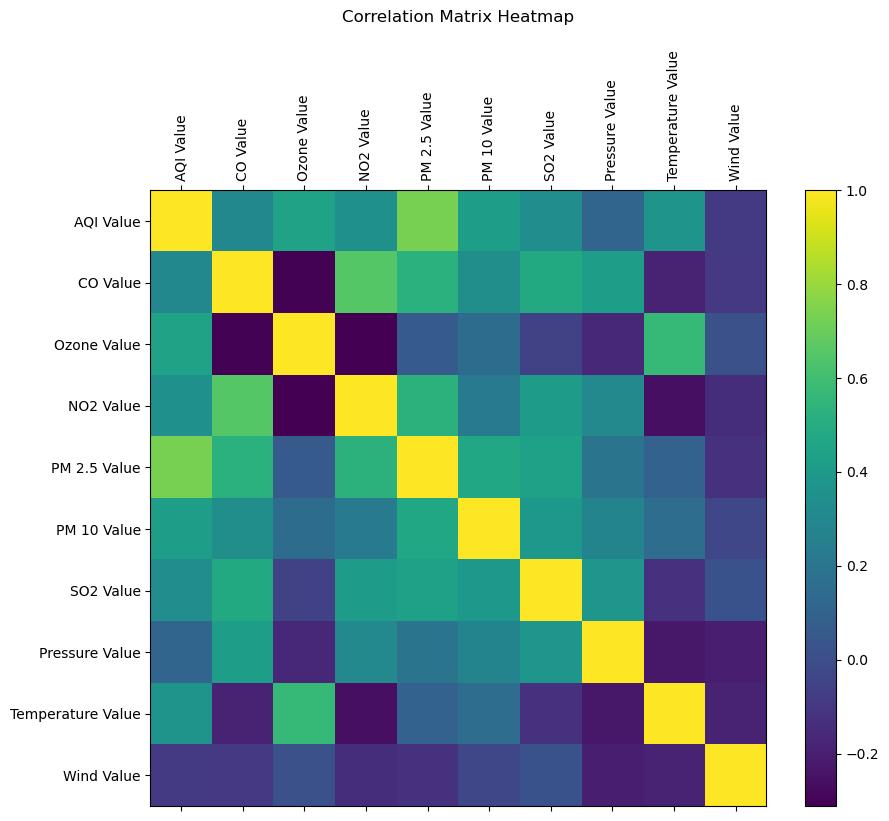

In [7]:
# Create a heatmap of the correlation values
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the correlation matrix
cax = ax.matshow(cor_matrix)
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(range(len(cor_matrix.columns)))
ax.set_yticks(range(len(cor_matrix.columns)))
ax.set_xticklabels(cor_matrix.columns, rotation=90)
ax.set_yticklabels(cor_matrix.columns)

plt.title("Correlation Matrix Heatmap", pad=20)
plt.show()

In [8]:
cor_unstacked = cor_matrix.unstack().reset_index()
cor_unstacked.columns = ['Var 1', 'Var 2', 'Correlation']
# Remove self-correlations (where Variable_1 == Variable_2)
cor_unstacked = cor_unstacked[cor_unstacked['Var 1'] != cor_unstacked['Var 2']]

# Sort by absolute correlation (descending to get highest on top)
cor_unstacked['AbsCorr'] = cor_unstacked['Correlation'].abs()
cor_unstacked.sort_values(by='AbsCorr', ascending=False, inplace=True)

# Show top 10 pairs of correlated variables
top_10 = cor_unstacked.head(10)
print("Top 10 most strongly correlated pairs:")
display(top_10)

Top 10 most strongly correlated pairs:


,Var 1,Var 2,Correlation,AbsCorr
4,AQI Value,PM 2.5 Value,0.730262,0.730262
40,PM 2.5 Value,AQI Value,0.730262,0.730262
31,NO2 Value,CO Value,0.652616,0.652616
13,CO Value,NO2 Value,0.652616,0.652616
28,Ozone Value,Temperature Value,0.566573,0.566573
82,Temperature Value,Ozone Value,0.566573,0.566573
43,PM 2.5 Value,NO2 Value,0.529000,0.529000
34,NO2 Value,PM 2.5 Value,0.529000,0.529000
41,PM 2.5 Value,CO Value,0.523842,0.523842
14,CO Value,PM 2.5 Value,0.523842,0.523842


In [9]:
aqi_correlation = cor_matrix['AQI Value'].drop('AQI Value')
aqi_correlation_sorted = aqi_correlation.reindex(aqi_correlation.abs().sort_values(ascending = False).index)
display(aqi_correlation_sorted)

PM 2.5 Value         0.730262
Ozone Value          0.443898
PM 10 Value          0.417485
Temperature Value    0.366473
NO2 Value            0.344107
SO2 Value            0.331879
CO Value             0.300070
Pressure Value       0.117348
Wind Value          -0.087016
Name: AQI Value, dtype: float64

# Set up Feature and Target for Use

In [10]:
# Define features and include all and define target as AQI, leave out wind due to its very low correlation value
features = ['CO Value', 'Ozone Value', 'NO2 Value'
            ,'PM 2.5 Value', 'PM 10 Value', 'SO2 Value'
            ,'Temperature Value', 'Pressure Value']

target = "AQI Value"

# Assign features and target to x and y
X = df[features]
y = df[target]

In [11]:
# Train/Test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model Testing

Here the goal is to find a good base model for utilizing with EVT. We want to see decent results for most of the data and theorize that as the AQI increases, prediction will get worse.

### Linear Regression

In [12]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define model and fit on train data
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Do predictions
y_pred_train = lr.predict(X_train)

# Print train/test results
print("Linear Regression Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Linear Regression Train R2:  ", r2_score(y_train, y_pred_train))

print("Linear Regression RMSE:",np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))

Linear Regression Train RMSE: 13.094975956239598
Linear Regression Train R2:   0.7230892781741441
Linear Regression RMSE: 13.322323114564135
Linear Regression R2: 0.7246043480758062


Text(0.5, 1.0, 'Actual vs. Predicted: Linear Regression')

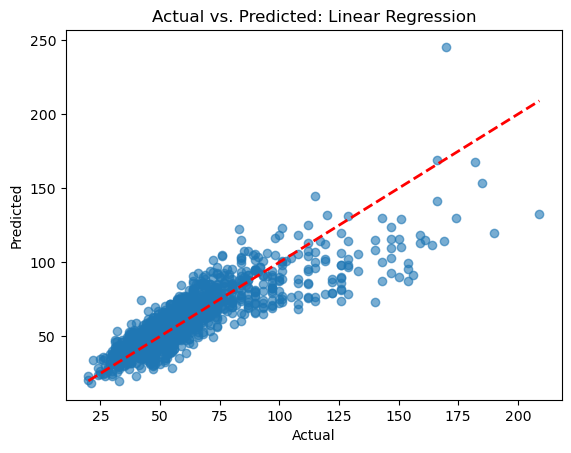

In [13]:
# Scatterplot to visualize predictions
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted: Linear Regression")

Linear regression performs decently, not much overfitting but metrics can improve.

### Ridge Regression

In [14]:
# Ridge Regression
from sklearn.linear_model import Ridge

# Define Ridge w/ Alpha 1
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Print metrics
y_pred_train = ridge.predict(X_train)
print("Ridge Regression Train RMSE:",np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Ridge Regression Train R2:  ", r2_score(y_train, y_pred_train))

print("Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("Ridge Regression R2:",r2_score(y_test, y_pred_ridge))

Ridge Regression Train RMSE: 14.044755226507698
Ridge Regression Train R2:   0.6814638619471362
Ridge Regression RMSE: 14.304521037786884
Ridge Regression R2: 0.6824999519363191


Text(0.5, 1.0, 'Actual vs. Predicted: Ridge Regression')

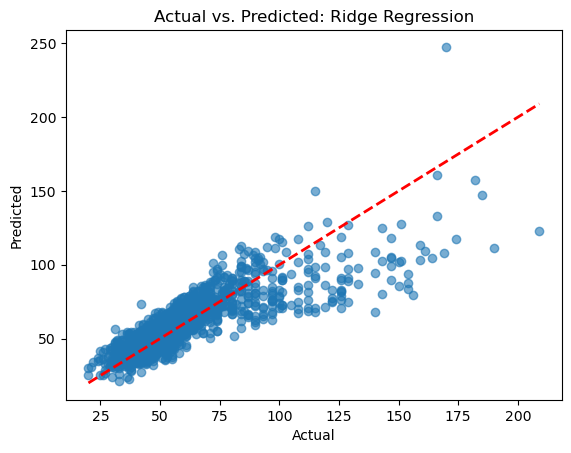

In [15]:
# Make scatterplot
plt.scatter(y_test,y_pred_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(),y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted: Ridge Regression")

### Lasso Regression

In [16]:
# Lasso Regression
from sklearn.linear_model import Lasso

# Define model and fit on data
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_train = lasso.predict(X_train)

# Print results
print("Lasso Regression Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Lasso Regression Train R2:  ", r2_score(y_train, y_pred_train))

y_pred_lasso = lasso.predict(X_test)
print("Lasso Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("Lasso Regression R2:", r2_score(y_test, y_pred_lasso))

Lasso Regression Train RMSE: 15.07109530761848
Lasso Regression Train R2:   0.6332078828448482
Lasso Regression RMSE: 15.401837584243847
Lasso Regression R2: 0.6319199896206193


Text(0.5, 1.0, 'Actual vs. Predicted: Lasso Regression')

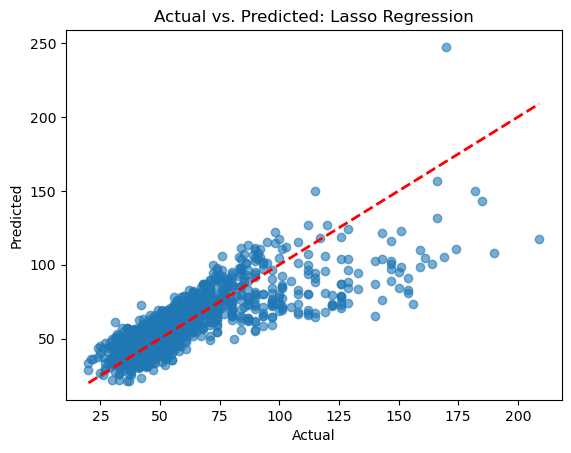

In [17]:
# Show scatterplot
plt.scatter(y_test, y_pred_lasso, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted: Lasso Regression")

### Bayes Ridge Regression

We try to improve on base Ridge by applying Bayes Theorm to achieve ideal hyperparameters.

In [18]:
# Bayesian Ridge
from sklearn.linear_model import BayesianRidge

# Define model and fit
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)

# Calculate and print metrics
y_pred_train = bayesian.predict(X_train)
print("Bayes Ridge Regression Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Bayes Ridge Regression Train R2:  ", r2_score(y_train, y_pred_train))


y_pred_bayes = bayesian.predict(X_test)
print("Bayesian Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_bayes)))
print("Bayesian Ridge Regression R2:", r2_score(y_test, y_pred_bayes))

Bayes Ridge Regression Train RMSE: 13.0950238519671
Bayes Ridge Regression Train R2:   0.7230872525324363
Bayesian Ridge Regression RMSE: 13.322204963145488
Bayesian Ridge Regression R2: 0.724609232845887


Text(0.5, 1.0, 'Bayes: Actual vs. Predicted')

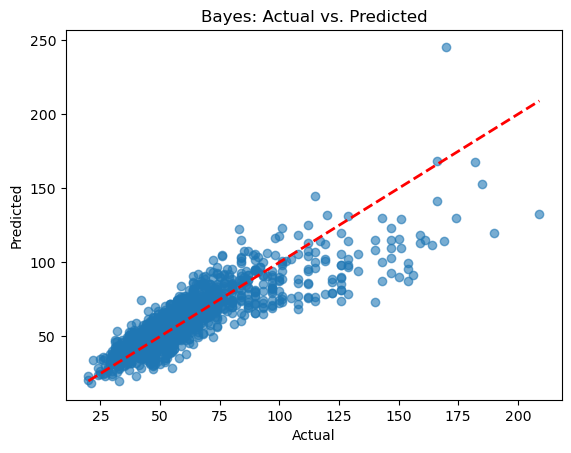

In [19]:
# Print scatterplot
plt.scatter(y_test, y_pred_bayes, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Bayes: Actual vs. Predicted")

We find some useful information about our dataset from Ridge/Lasso, multicollinearity does not seem to be an issue

### K-Nearest Neighbor

In [20]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

# Define KNN regressor
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

# Predict and print metrics
y_pred_train = knn.predict(X_train)


print("KNN Train RMSE:",np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("KNN Train R2:  ",r2_score(y_train, y_pred_train))


y_pred_knn = knn.predict(X_test)
print("KNN Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("KNN Regression R2:", r2_score(y_test, y_pred_knn))

KNN Train RMSE: 11.595747396031069
KNN Train R2:   0.7828659899292324
KNN Regression RMSE: 13.861135315815439
KNN Regression R2: 0.7018774960271402


Text(0.5, 1.0, 'KNN: Actual vs. Predicted')

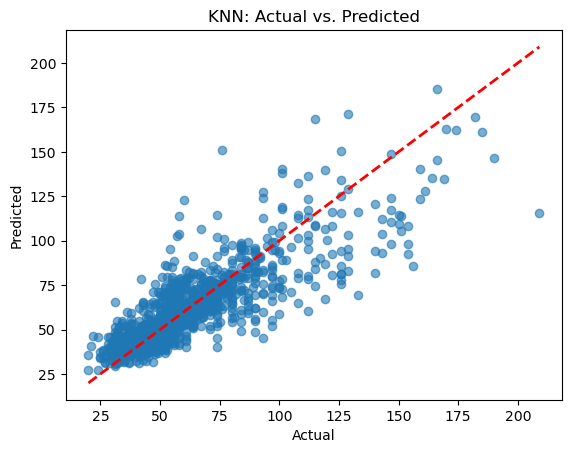

In [21]:
# Look at scatterplot
plt.scatter(y_test, y_pred_knn, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("KNN: Actual vs. Predicted")

Bad results from KNN and an increase in the variance between train and test

### ADABoost

In [22]:
# ADA Boost Regressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Define the base estimator
base_estimator = DecisionTreeRegressor(max_depth=3, random_state=42)

# Initialize the AdaBoost Regressor
ada_boost = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=8,       # Number of boosting rounds
    learning_rate=1.0,     # Learning rate shrinks the contribution of each regressor
    random_state=42
)


# Fit AdaBoost
ada_boost.fit(X_train, y_train)

# Predict on the test set
y_pred_ada = ada_boost.predict(X_test)

y_pred_train = ada_boost.predict(X_train)

# Calculate metrics
mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)

# Print results
print("ADABoost Regression Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("ADABoost Regression Train R2:  ", r2_score(y_train, y_pred_train))

print("AdaBoost Regressor RMSE:", np.sqrt(mse_ada))
print("AdaBoost Regressor R2 score:", r2_ada)

ADABoost Regression Train RMSE: 11.47574558537405
ADABoost Regression Train R2:   0.7873368786351644
AdaBoost Regressor RMSE: 12.165685619568876
AdaBoost Regressor R2 score: 0.7703479467613715


Text(0.5, 1.0, 'AdaBoost: Actual vs. Predicted')

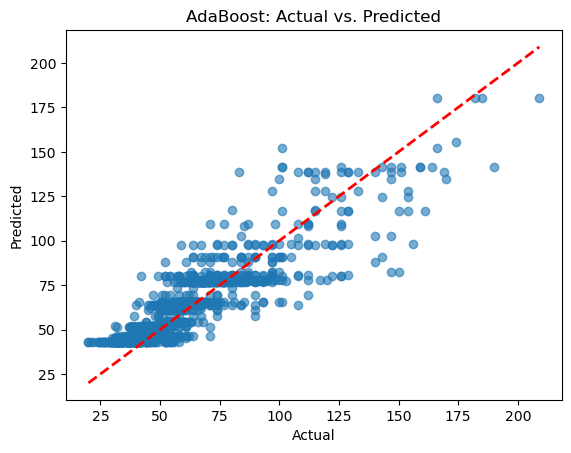

In [23]:
# Look at scatterplot for ADABoost
plt.scatter(y_test, y_pred_ada, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("AdaBoost: Actual vs. Predicted")

Text(0.5, 1.0, 'AdaBoost: Learning Curve over Boosting Rounds')

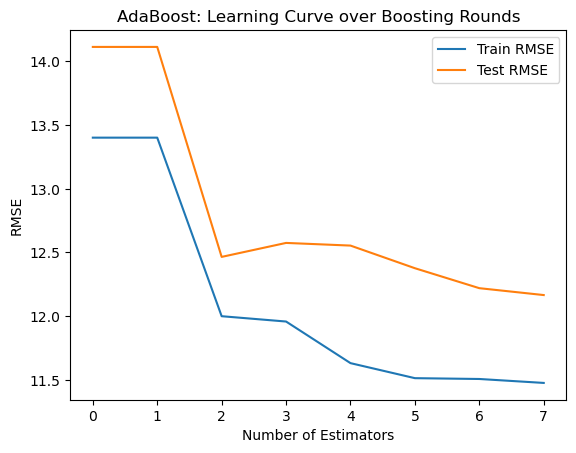

In [24]:
# Compute staged predictions
train_errors, test_errors = [], []

for y_train_pred in ada_boost.staged_predict(X_train):
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    
for y_test_pred in ada_boost.staged_predict(X_test):
    test_errors.append(mean_squared_error(y_test, y_test_pred))

# Print learning curve over rounds
plt.plot(np.sqrt(train_errors), label="Train RMSE")
plt.plot(np.sqrt(test_errors), label="Test RMSE")
plt.xlabel("Number of Estimators")
plt.ylabel("RMSE")
plt.legend()
plt.title("AdaBoost: Learning Curve over Boosting Rounds")

Ideal number of estimators is 8, we find the best metrics with this number of estimators. ADABoost does decently and train/test show little overfitting but metrics could be better.

# Random Forest Regressor

In [24]:
# Define RFR model, use cross validation score and give RSME of each fold
rfr = RandomForestRegressor()

cross_val = cross_val_score(rfr, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error")

rfr_mse = -cross_val
rfr_rsme = np.sqrt(rfr_mse)

print(f"CV RSME for each fold: {rfr_rsme}")

CV RSME for each fold: [10.15394138 11.07070523  9.42169352 10.13816264  9.80761025]


In [25]:
# Fit model to training data
rfr.fit(X_train, y_train)

# Predict data on test datasets
y_train_predict = rfr.predict(X_train)
y_test_predict = rfr.predict(X_test)

# Define and print some metrics for evaluation
rfr_mse_train = mean_squared_error(y_train, y_train_predict)
rfr_mse_test = mean_squared_error(y_test, y_test_predict)

rfr_rsme_train = np.sqrt(rfr_mse_train)
rfr_rsme_test = np.sqrt(rfr_mse_test)

rfr_r2_train = r2_score(y_train, y_train_predict)
rfr_r2_test = r2_score(y_test, y_test_predict)

# Print metrics
print("Metrics: \n")

print(f"TRAIN RMSE: {rfr_rsme_train:.2f}")
print(f"TEST  RMSE: {rfr_rsme_test:.2f}")
print(f"TRAIN R^2 : {rfr_r2_train:.3f}")
print(f"TEST  R^2 : {rfr_r2_test:.3f}")

Metrics: 

TRAIN RMSE: 3.76
TEST  RMSE: 9.72
TRAIN R^2 : 0.977
TEST  R^2 : 0.858


We find good base results, can we improve on these to raise the Test score to the 90's?

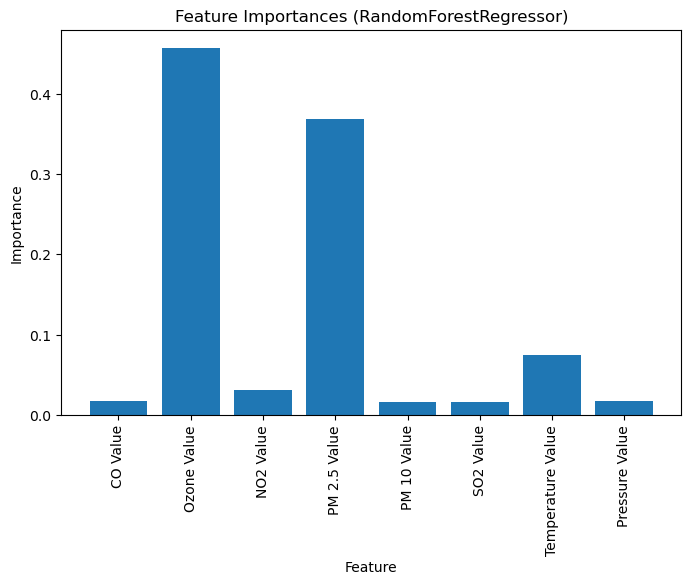

In [26]:
# Find which features are contributing the most to the regression
important_feat = rfr.feature_importances_
feature_names = X_train.columns

# Plot important features
plt.figure(figsize=(8, 5))
plt.bar(feature_names, important_feat)
plt.title("Feature Importances (RandomForestRegressor)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

We find here that PM 2.5 and Ozone are contributing the most, can consider dropping all other variables for future modeling. Interestingly Ozone takes up the most of the impotance despite PM 2.5 being much more correlated in the matrix.

The RFR was able to do decently well predicting AQI but there is a large variance between a very good train R^2 score (0.977) and a decent R^2 test score (0.82). This shows the model is very good in training but falters an unacceptable amount on the test dataset. Try L1 and L2 reg. to see if model can imporve?

In [27]:
# Define sets of parameters to try
par_dist = {'n_estimators': [50,100,200],
            "max_depth":[None, 5, 10,20],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 5, 7,10],}

# Use RandomSearchCV to find the best parameters
ran_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),param_distributions=par_dist,
    n_iter=10,scoring='neg_mean_squared_error',cv=5,random_state=42)

# Fit model on training data and print best parameters
ran_search.fit(X_train, y_train)
best_rfr = ran_search.best_estimator_
print("Best params:", ran_search.best_params_)

Best params: {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_depth': None}


In [28]:
# Define and print some metrics for the best case RFR model
test_best_rfr = best_rfr.predict(X_test)
test_rsme_best_rfr = np.sqrt(mean_squared_error(y_test,test_best_rfr))
test_r2_best_rfr = r2_score(y_test, test_best_rfr)

# Print metrics
print(f"Best model test RMSE: {test_rsme_best_rfr:.2f}")
print(f"Best model test R^2: {test_r2_best_rfr:.2f}")

Best model test RMSE: 9.62
Best model test R^2: 0.86


Text(0.5, 1.0, 'Actual vs. Predicted')

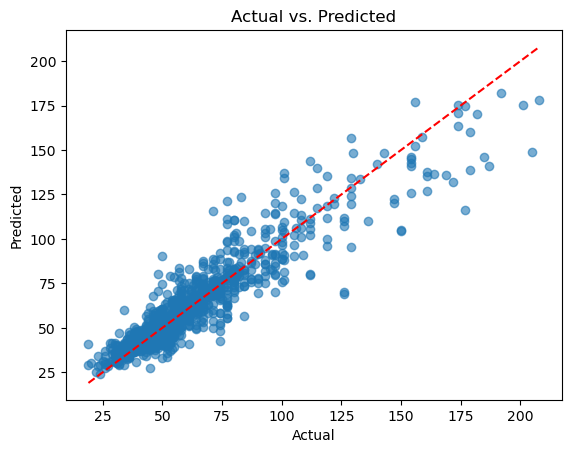

In [29]:
# Show scatterplot
plt.scatter(y_test, test_best_rfr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")

In [30]:
# Redefine with most important features
rfr_features = ['Ozone Value','PM 2.5 Value']

rfr_target = "AQI Value"

# Assign features and target to x and y
rfr_X = df[rfr_features]
rfr_y = df[rfr_target]

In [31]:
# Train/Test split 80/20
rfr_X_train, rfr_X_test, rfr_y_train, rfr_y_test = train_test_split(rfr_X, rfr_y, test_size=0.2)

In [32]:
# Define a new regressor with important features
imp_rfr = RandomForestRegressor()

# Cross Val again
cross_val = cross_val_score(imp_rfr, rfr_X_train, rfr_y_train, cv = 5, scoring = "neg_mean_squared_error")

rfr_mse = -cross_val
rfr_rsme = np.sqrt(rfr_mse)

print(f"CV RSME for each fold: {rfr_rsme}")

CV RSME for each fold: [11.42488547 13.08371588 11.80104152 12.51034416 12.56143014]


In [33]:
# Fit model to training data
imp_rfr.fit(rfr_X_train, rfr_y_train)

RandomForestRegressor()

In [34]:
# Predict data on test datasets
imp_y_train_predict = imp_rfr.predict(rfr_X_train)
imp_y_test_predict = imp_rfr.predict(rfr_X_test)

# Define and print metrics
imp_rfr_mse_train = mean_squared_error(rfr_y_train, imp_y_train_predict)
imp_rfr_mse_test = mean_squared_error(rfr_y_test, imp_y_test_predict)

imp_rfr_rsme_train = np.sqrt(imp_rfr_mse_train)
imp_rfr_rsme_test = np.sqrt(imp_rfr_mse_test)

imp_rfr_r2_train = r2_score(rfr_y_train, imp_y_train_predict)
imp_rfr_r2_test = r2_score(rfr_y_test, imp_y_test_predict)

print("Metrics: \n")

print(f"TRAIN RMSE: {imp_rfr_rsme_train:.2f}")
print(f"TEST  RMSE: {imp_rfr_rsme_test:.2f}")
print(f"TRAIN R^2 : {imp_rfr_r2_train:.3f}")
print(f"TEST  R^2 : {imp_rfr_r2_test:.3f}")

Metrics: 

TRAIN RMSE: 4.51
TEST  RMSE: 12.00
TRAIN R^2 : 0.968
TEST  R^2 : 0.753


Overall good metrics but a decently large variance between train and test even after hyperparameter optimization. We believe this is the highest we can get test to be.

# XG Boost

In [35]:
# Define XGBoost regressor
xgb = XGBRegressor()

# Use cross_val_score with negative MSE
scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring="neg_mean_squared_error",n_jobs=-1)
# Calculate mse score
xgb_mse_scores = -scores
xgb_rmse_scores = np.sqrt(xgb_mse_scores)

print("Cross-Validation RMSE (for each fold):", xgb_rmse_scores)
print(f"Mean CV RMSE: {xgb_rmse_scores.mean():.3f}  (+/- {xgb_rmse_scores.std():.3f})")

Cross-Validation RMSE (for each fold): [10.56681347 11.55152562  9.55011581 10.63968425 10.39472612]
Mean CV RMSE: 10.541  (+/- 0.638)


In [36]:
# Fit XGB model, predict on test set, and print out metics
xgb.fit(X_train, y_train)

# Predictions on training set
xgb_y_train_pred = xgb.predict(X_train)
# Predictions on test set
xgb_y_test_pred = xgb.predict(X_test)


# Define metrics
xgb_mse_train = mean_squared_error(y_train, xgb_y_train_pred)
xgb_mse_test  = mean_squared_error(y_test,  xgb_y_test_pred)

xgb_rmse_train = np.sqrt(xgb_mse_train)
xgb_rmse_test  = np.sqrt(xgb_mse_test)
xgb_r2_train   = r2_score(y_train, xgb_y_train_pred)
xgb_r2_test    = r2_score(y_test,  xgb_y_test_pred)

# Print metrics
print("XGBRegressor Performance\n")
print(f"TRAIN RMSE: {xgb_rmse_train:.2f}")
print(f"TEST  RMSE: {xgb_rmse_test:.2f}")
print(f"TRAIN R^2:  {xgb_r2_train:.3f}")
print(f"TEST  R^2:  {xgb_r2_test:.3f}")

XGBRegressor Performance

TRAIN RMSE: 3.13
TEST  RMSE: 10.32
TRAIN R^2:  0.984
TEST  R^2:  0.840


In [37]:
# Trying to improve base XG Boost by finding best parameters and training a model on those
param_dist = param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [2, 3, 5],
    "learning_rate": [0.01, 0.05],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "reg_alpha": [0, 0.1, 0.5,1,1.5],   # L1 regularization
    "reg_lambda": [1, 5, 10,15,20]      # L2 regularization
}

xgb_search = RandomizedSearchCV(estimator=XGBRegressor(random_state=42),param_distributions=param_dist,
                                scoring="neg_mean_squared_error",n_iter=20,cv=5,random_state=42)

# Fit best case model for XGB
xgb_search.fit(X_train, y_train)

print("Best parameters:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_

Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [38]:
# Make predictions on test set
y_test_pred_best_xgb = best_xgb.predict(X_test)

# Define metrics and print
mse_test_best_xgb = mean_squared_error(y_test, y_test_pred_best_xgb)
rmse_test_best_xgb = np.sqrt(mse_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_test_pred_best_xgb)

print("Tuned XGBRegressor")
print(f"RMSE on test set: {rmse_test_best_xgb:.2f}")
print(f"R^2 on test set:  {r2_test_best_xgb:.2f}")

Tuned XGBRegressor
RMSE on test set: 9.42
R^2 on test set:  0.87


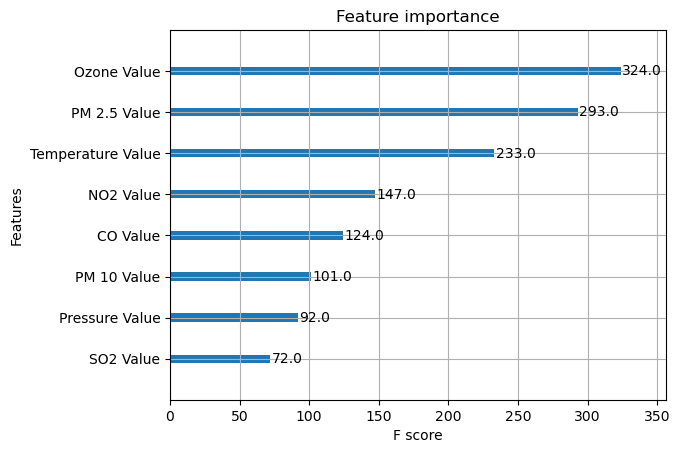

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot the important features
plot_importance(best_xgb, max_num_features=15)
plt.show()

Text(0.5, 1.0, 'Actual vs. Predicted')

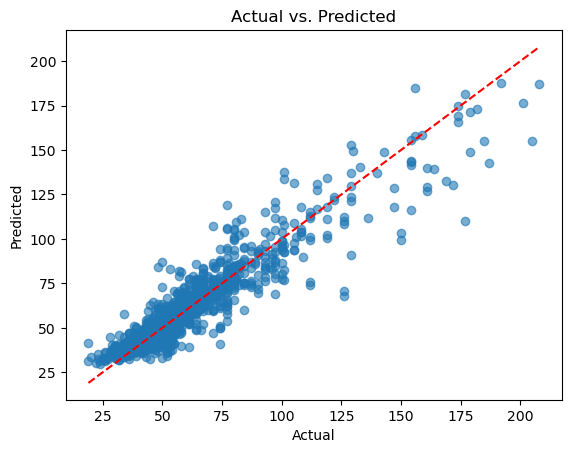

In [40]:
# Show scatterplot
plt.scatter(y_test, y_test_pred_best_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted")

Text(0.5, 1.0, 'Learning Curve')

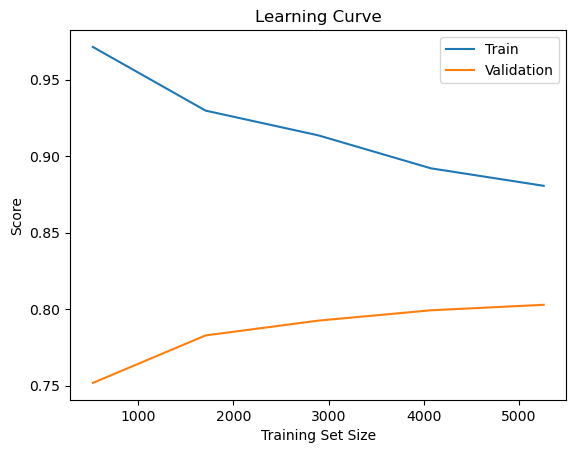

In [41]:
from sklearn.model_selection import learning_curve
# Define and display learning curve
train_sizes, train_scores, val_scores = learning_curve(best_xgb, X, y, cv=5)
plt.plot(train_sizes, np.mean(train_scores,1), label='Train')
plt.plot(train_sizes, np.mean(val_scores,1), label='Validation')
plt.xlabel("Training Set Size")
plt.ylabel("Score")
plt.legend()
plt.title("Learning Curve")

Text(0.5, 1.0, 'Residuals vs. Predicted')

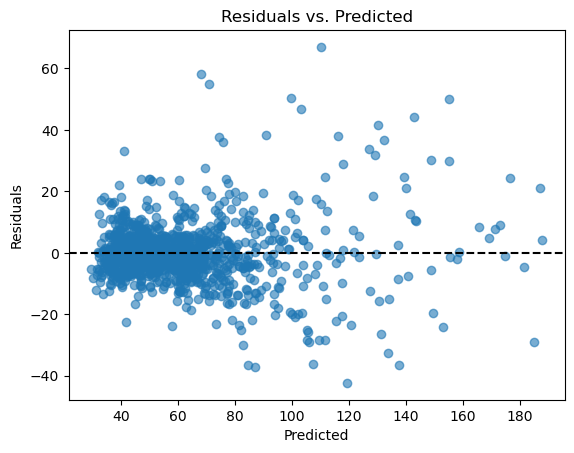

In [42]:
# Look at residuals
residuals = y_test - y_test_pred_best_xgb
plt.scatter(y_test_pred_best_xgb, residuals, alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted")

Text(0.5, 1.0, 'QQ‐Plot of Residuals')

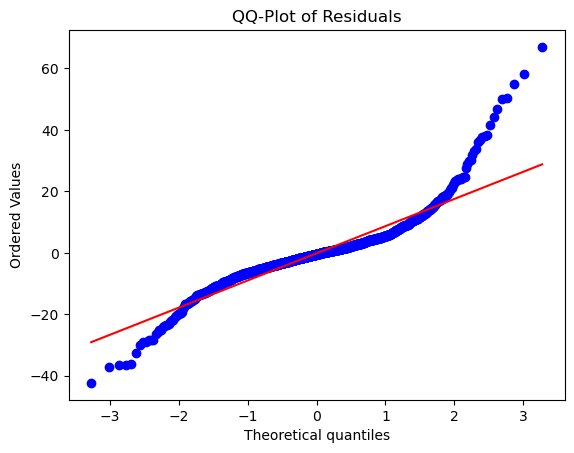

In [43]:
import scipy.stats as stats
# Display Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ‐Plot of Residuals")

In [44]:
# Redefine with important features
xgb_features = ['Ozone Value','PM 2.5 Value']

xgb_target = "AQI Value"

# Assign features and target to x and y
xgb_X = df[xgb_features]
xgb_y = df[xgb_target]

In [45]:
# Train/Test split 80/20
xgb_X_train, xgb_X_test, xgb_y_train, xgb_y_test = train_test_split(xgb_X, xgb_y, test_size=0.2)

In [46]:
# Use random CV for ideal params
imp_xgb_search = RandomizedSearchCV(estimator=XGBRegressor(random_state=42),param_distributions=param_dist,
                                scoring="neg_mean_squared_error",n_iter=20,cv=5,random_state=42)

# Fit best case model for XGB
imp_xgb_search.fit(xgb_X_train, xgb_y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=20,
                   param_distributions={'colsample_bytree': [0.6, 0.8],
                                        'learning_rate': [0.01, 0.05],
                                        'max_depth': [2, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.1, 0.5, 1, 1.5],
                                        'reg_lambda': [1, 5, 10, 15, 20],
                                        'subsample': [0.6, 0.8]},
                   random_state=42, scoring='neg_mean_squared_error')

In [47]:
imp_best_xgb = imp_xgb_search.best_estimator_

In [48]:
# Predict data on test datasets
xgb_imp_y_train_predict = imp_best_xgb.predict(xgb_X_train)
xgb_imp_y_test_predict = imp_best_xgb.predict(xgb_X_test)

# Define and print some metrics for evaluation
imp_xgb_mse_train = mean_squared_error(xgb_y_train, xgb_imp_y_train_predict)
imp_xgb_mse_test = mean_squared_error(xgb_y_test, xgb_imp_y_test_predict)

xgb_imp_rsme_train = np.sqrt(imp_xgb_mse_train)
xgb_imp_rsme_test = np.sqrt(imp_xgb_mse_test)

imp_xgb_r2_train = r2_score(xgb_y_train, xgb_imp_y_train_predict)
imp_xgb_r2_test = r2_score(xgb_y_test, xgb_imp_y_test_predict)

print("Metrics: \n")

print(f"TRAIN RMSE: {xgb_imp_rsme_train:.2f}")
print(f"TEST  RMSE: {xgb_imp_rsme_test:.2f}")
print(f"TRAIN R^2 : {imp_xgb_r2_train:.3f}")
print(f"TEST  R^2 : {imp_xgb_r2_test:.3f}")

Metrics: 

TRAIN RMSE: 11.00
TEST  RMSE: 11.20
TRAIN R^2 : 0.803
TEST  R^2 : 0.810


Results from train and test show variance has gotten better, but overall results are worse than with all the features. Similarly to RFR, test train results have a decent amount of variance but still high scores. We decide to use the model with all features.

## XGBoost with time steps

Added post presentation to explore suggestions about improving the value of the model.

In [49]:
from sklearn.model_selection import TimeSeriesSplit

# Create shifted targets
horizons = [1, 3, 7]
max_h = max(horizons)
y_multi = pd.concat([df[target].shift(-h) for h in horizons], axis=1)
y_multi.columns = [f"{target}_t+{h}" for h in horizons]

# Drop the last max_h rows (they have NaN in at least one shifted column)
df_sup = df.iloc[:-max_h].copy()
y_sup  = y_multi.iloc[:-max_h].copy()

X_sup = df_sup[features]

In [50]:
# Time-aware train/test split (80/20)
split_idx = int(len(X_sup) * 0.8)
multi_X_train, multi_X_test = X_sup.iloc[:split_idx], X_sup.iloc[split_idx:]
multi_y_train, multi_y_test = y_sup.iloc[:split_idx], y_sup.iloc[split_idx:]

# Hyper param grid
param_dist = {
    "n_estimators":[100, 200, 300],
    "max_depth":[2, 3, 5],
    "learning_rate":[0.01, 0.05],
    "subsample": [0.6, 0.8],
    "colsample_bytree":[0.6, 0.8],
    "reg_alpha":[0, 0.1, 0.5, 1, 1.5],
    "reg_lambda": [1, 5, 10, 15, 20]
}

In [51]:
# TimeSeries CV splitter
tscv = TimeSeriesSplit(n_splits=5)

# Loop over time steps
best_models = {}
results= {}

In [54]:
# Loop to go through each timestep and make predictions
for idx, h in enumerate(horizons):
    print(f"\n Horizon t+{h} days")
    multi_y_tr = multi_y_train.iloc[:, idx]
    multi_y_te = multi_y_test.iloc[:, idx]

    # RandomizedSearch
    multi_base = XGBRegressor(random_state=42)
    multi_search = RandomizedSearchCV(
        multi_base,
        param_distributions=param_dist,
        n_iter=20,
        cv=tscv,
        scoring="neg_mean_squared_error",
        random_state=42,
        n_jobs=-1
    )

    # fit and grab best params
    multi_search.fit(multi_X_train, multi_y_tr)
    multi_best = multi_search.best_estimator_
    print("Best params:", multi_search.best_params_)

    # Predict & eval on test
    multi_y_pred = multi_best.predict(multi_X_test)
    mse = mean_squared_error(multi_y_te, multi_y_pred)
    rmse = np.sqrt(mse)
    r2= r2_score(multi_y_te, multi_y_pred)
    print(f" Test  RMSE: {rmse:.3f},  r2: {r2:.3f}")

    # Store results
    best_models[h] = multi_best
    results[h] = {"rmse": rmse, "r2": r2}


 Horizon t+1 days
Best params: {'subsample': 0.8, 'reg_lambda': 20, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
 Test  RMSE: 16.455,  r2: 0.263

 Horizon t+3 days
Best params: {'subsample': 0.8, 'reg_lambda': 15, 'reg_alpha': 1.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
 Test  RMSE: 19.011,  r2: 0.016

 Horizon t+7 days
Best params: {'subsample': 0.8, 'reg_lambda': 15, 'reg_alpha': 1.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
 Test  RMSE: 19.913,  r2: -0.074


We try to implement a time step feature for XGBoost but does not work out, we will move forward with the base XGBoost and others to the EVT part. We try to make the model have multiple uses in future predictions and extreme value but fail in producing worthy results for EVT addition on time step models.

### LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [56]:
lstm_X = df.drop(['AQI Value', 'Date', 'AQI Class', 'Wind Value'], axis=1).values
lstm_y = df['AQI Value'].values

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(lstm_X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(lstm_y.reshape(-1, 1))

X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [57]:
lstm_X_train, lstm_X_test, lstm_y_train, lstm_y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [58]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

C:\Users\danny\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
history = model.fit(lstm_X_train, lstm_y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

y_pred_scaled = model.predict(lstm_X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(lstm_y_test)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0253 - val_loss: 0.0115
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 9/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 10/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 11/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 12/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

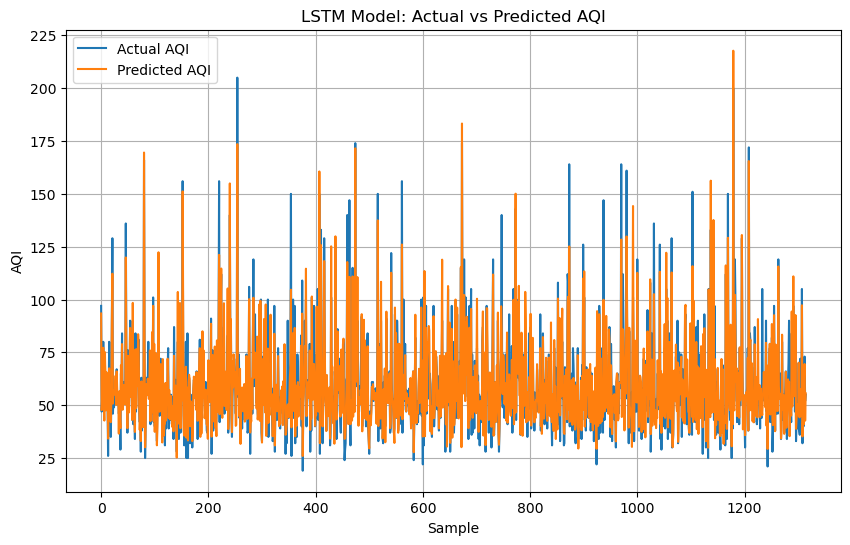

In [60]:
plt.figure(figsize=(10,6))
plt.plot(y_actual, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('LSTM Model: Actual vs Predicted AQI')
plt.xlabel('Sample')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
mse_lstm = mean_squared_error(lstm_y_test, y_pred_scaled)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(lstm_y_test, y_pred_scaled)

print("LSTM")


print(f"RMSE on test set: {rmse_lstm:.2f}")
print(f"R^2 on test set:  {r2_lstm:.2f}")

LSTM
RMSE on test set: 0.05
R^2 on test set:  0.85


With no timestep we get good r2, RMSE score is inaccurate. We will invert later and get the correct score. Lets try with timestep.

### LSTM w Timestep
Previous LSTM implemented without timestep behaves essentially like XG/RFR and performs decently, we explore adding a timestep to see if LSTM is still good.

In [62]:
# parameters
window_size = 21

raw_X = df.drop(['AQI Value','Date','AQI Class','Wind Value'], axis=1).values
raw_y = df['AQI Value'].values.reshape(-1,1)
window_scaler_X = MinMaxScaler()
window_X_scaled = window_scaler_X.fit_transform(raw_X)

window_scaler_y = MinMaxScaler()
window_y_scaled = window_scaler_y.fit_transform(raw_y)

In [63]:
# Helper to slice sequences
def make_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i : i + window])
        ys.append(y[i + window])
    return np.array(Xs), np.array(ys)

In [64]:
# create sequence
X_seq, y_seq = make_sequences(window_X_scaled, window_y_scaled, window_size)
# Split data

w_lstm_X_train, w_lstm_X_test, w_lstm_y_train, w_lstm_y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
# build model with new input_shape
window_model = Sequential([
    LSTM(64, activation='relu',
         input_shape=(window_size, w_lstm_X_train.shape[2])),
    Dense(1)
])
window_model.compile(optimizer='adam', loss='mse')

# — train —
history = window_model.fit(
    w_lstm_X_train, w_lstm_y_train,
    epochs=200, batch_size=64,
    validation_split=0.2, verbose=1
)

Epoch 1/200


C:\Users\danny\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0313 - val_loss: 0.0140
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0115 - val_loss: 0.0131
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0118 - val_loss: 0.0126
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0107 - val_loss: 0.0125
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - val_loss: 0.0114
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0105 - val_loss: 0.0132
Epoch 9/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0099 - val_loss: 0.0126
Epoch 10/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 11/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 12/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

In [66]:
# predict and inverse-scale
y_pred_train_scaled = window_model.predict(w_lstm_X_train)
y_pred_test_scaled  = window_model.predict(w_lstm_X_test)

y_pred_train = window_scaler_y.inverse_transform(y_pred_train_scaled)
y_pred_test  = window_scaler_y.inverse_transform(y_pred_test_scaled)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [67]:
y_train_actual = scaler_y.inverse_transform(w_lstm_y_train)
y_test_actual  = scaler_y.inverse_transform(w_lstm_y_test)

# compute metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_pred_train))
train_r2   = r2_score(y_train_actual, y_pred_train)

test_rmse  = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
test_r2    = r2_score(y_test_actual, y_pred_test)

print(f"Using a window of {window_size} timesteps\n")
print(f"LSTM Train RMSE: {train_rmse:.3f}")
print(f"LSTM Train R²:   {train_r2:.3f}")
print(f"\nLSTM Test RMSE:  {test_rmse:.3f}")
print(f"LSTM Test R²:    {test_r2:.3f}")

Using a window of 21 timesteps

LSTM Train RMSE: 14.686
LSTM Train R²:   0.661

LSTM Test RMSE:  19.104
LSTM Test R²:    0.370


At 21 timesteps, we get the best results, but not better than LSTM with none. LSTM when employed correctly with timesteps, we see a sharp decreas in prediction, indicating that temporal and time-based features are not good for AQI prediction. Since the non timestep LSTM is essentially working as a single step feed forward net. Since this gives us good results and LSTM with timesteps gives worse results, we can conclude that temporal and time-based memory aspect is not ideal for Baltimore AQI prediction. Out of curiosity, we continue to employ original iteration of LSTM to see how it interacts with EVT.

# Extreme Value Analysis

The main goal of the project is to analyze how EVT interacts with different models that perform well with base predictions. We use our models with the best results which are XGBoost, RFR, and LSTM w/o timesteps. Unfortunately, trying to make future predictions did not pan out so we suggest using current data models combined with EVT to see if we can improve scores or discover something new about the right tail of our dataset. 

In [68]:
# Imports, you will need to install pyextremes to run this code, if it Jupyter try !pip install pyextremes
# it can be a bit of a pain to install I think so if this doesnt work let me know and I can find the long version
# that should ensure download
from pyextremes import get_extremes, get_return_periods
from pyextremes.plotting import plot_extremes

In [69]:
# Define new dataframe for EVA analysis
df_EVA = df[['Date', 'AQI Value']].copy()
df_EVA['Date'] = pd.to_datetime(df_EVA['Date'])
df_EVA.set_index('Date', inplace=True)

print(df_EVA.head())

            AQI Value
Date                 
2006-01-01         66
2006-01-02         86
2006-01-03         41
2006-01-04         67
2006-01-05         56


In [70]:
# Pass the AQI Value series to get_extremes (imported module) and use Block Maxima method
extremes = get_extremes(df_EVA['AQI Value'], method="BM")

,AQI Value,exceedance probability,return period
Date,,,
2020-07-28,119.0,0.947368,1.055556
2022-06-30,122.0,0.894737,1.117647
2013-07-18,133.0,0.842105,1.187500
2014-06-16,136.0,0.789474,1.266667
2021-08-25,140.0,0.736842,1.357143


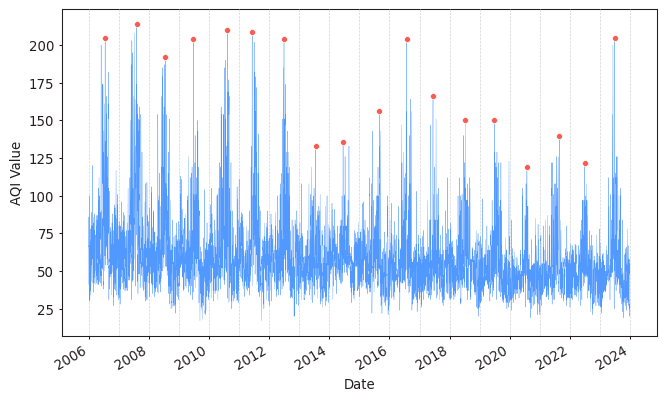

In [71]:
# Plot the extremes using BM
plot_extremes(
    ts=df_EVA['AQI Value'],
    extremes=extremes,
    extremes_method="BM", # Here we use the block maxima method
    extremes_type="high", # Want to find the right-tailed extremes
    block_size="365.2425D", # Set block size to industry standard of 1 year
)

# Also get retunr periods for insight
return_periods = get_return_periods(
    ts=df_EVA,
    extremes=extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    return_period_size="365.2425D",
    plotting_position="weibull",
)
return_periods.sort_values("return period", ascending=True).head()

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Date', ylabel='AQI Value'>)

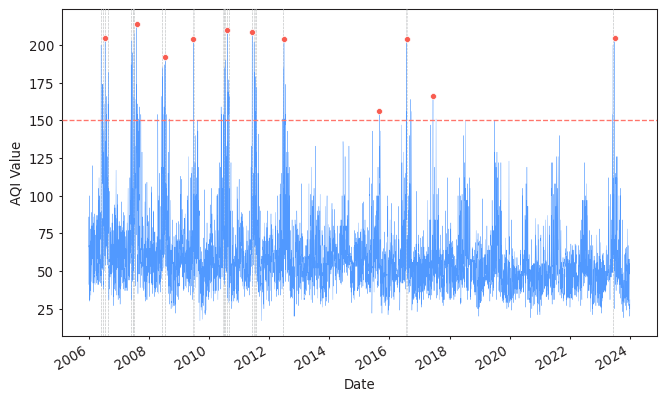

In [72]:
# Try again using POTS method this time
extremes = get_extremes(extremes, "POT", threshold=150, r="24h")
plot_extremes(
    ts=df_EVA['AQI Value'],
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    threshold=150,
    r="24h",
)

In [73]:
# Import genparto as that is the model that is associated with the POTS method
from scipy.stats import genpareto

# Use threshold of 150
threshold = 150

# Define new df of just the exceedaces
exceedances=df.loc[df['AQI Value']>threshold,'AQI Value']

Fitted GPD Parameters:

Shape:  -0.3194786191406871
Location:  0
Scale:  27.57389395411269


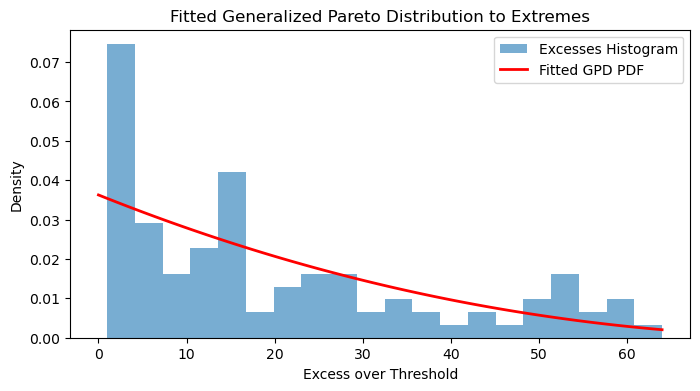

In [74]:
# Check that there are enough extreme values to fit a distribution, we want to ensure we are getting enough samples for the
# genpareto model can fit properly
if len(exceedances) < 10:
    print("Not enough data above the threshold to reliably fit a GPD.")
else:
    # Compute the excesses (how far above the threshold each observation is)
    excess = exceedances - threshold
    # Here we get the shape, loc, and scale. These are crucial in future calculations
    shape, loc, scale = genpareto.fit(excess,floc=0)

    print("Fitted GPD Parameters:\n")
    print("Shape: ", shape)
    print("Location: ", loc)
    print("Scale: ", scale)
    # Define x to fir the genpareto distribution
    x = np.linspace(0,excess.max(),100)
    fitted_pdf = genpareto.pdf(x,shape,loc=loc, scale=scale)
    
    # Plot the GPD's fit
    plt.figure(figsize=(8, 4))
    plt.hist(excess, bins=20, density=True, alpha=0.6, label='Excesses Histogram')
    plt.plot(x, fitted_pdf, 'r-', lw=2, label='Fitted GPD PDF')
    plt.xlabel('Excess over Threshold')
    plt.ylabel('Density')
    plt.title('Fitted Generalized Pareto Distribution to Extremes')
    plt.legend()
    plt.show()

In [75]:
# Get the probability that AQI will go over a threshold given it is at 150
for i in range(155, 205, 5):
    excess = i - threshold
    p_exceed = genpareto.sf(excess, c=shape, loc=0, scale=scale)
    print(f"P(AQI > {i} | AQI > {threshold}): {p_exceed:.4f}")

# Simulate some potential extreme values given our distribution
simulated_exceedances = genpareto.rvs(c=shape, loc=0, scale=scale, size=5)
simulated_AQI = threshold + simulated_exceedances
print("Simulated extreme AQI values:", simulated_AQI)

P(AQI > 155 | AQI > 150): 0.8296
P(AQI > 160 | AQI > 150): 0.6801
P(AQI > 165 | AQI > 150): 0.5501
P(AQI > 170 | AQI > 150): 0.4382
P(AQI > 175 | AQI > 150): 0.3428
P(AQI > 180 | AQI > 150): 0.2627
P(AQI > 185 | AQI > 150): 0.1963
P(AQI > 190 | AQI > 150): 0.1424
P(AQI > 195 | AQI > 150): 0.0996
P(AQI > 200 | AQI > 150): 0.0665
Simulated extreme AQI values: [152.55428166 189.93003346 182.89441533 181.62331277 200.33531696]


In [76]:
# Parameters extracted from model fitting
u = 150                      #threshold
xi = -0.3194786191406871    # shape
beta = 27.57389395411269     # scale
p = 0.90                    # target probability

In [77]:
return_level = u + (beta/xi) * ((1-p) ** (-xi) - 1)
print(f"Return Level at the 90th percentile: {return_level:.2f}")

Return Level at the 90th percentile: 194.95


In [78]:
# Ensure Date is a datetime and the DataFrame is sorted by date
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [79]:
# Define function to adjust predictions above threshold to EVT prediction, this function takes the predicted values from the
# regressor model (which is why it is important to train a good regressor), his_values will be the exceedances and used to
# calculate excess. Threshold and prop are both their pre-deined variables

def adjust_prediction(regressor_model, his_values, threshold=threshold, prob=p):
    # Fit GPD only on data that exceeds threshold
    his_exceedance=his_values[his_values>threshold]

    # Make sure there are enough samples to reliably fit a model, in this case we set it to 10 although the actual number is
    # much higher
    if len(his_exceedance) < 10:
        return regressor_model

    # Calculate excess, this represents how much above the thershold each instance is.This will be used to fit the genpareto
    excess = his_exceedance - threshold

    # Fit the genpareto on the excess and get shape, loc, and scale. These are important for internal genpareto calculations
    # when combining models with regressor
    shape, loc, scale = genpareto.fit(excess, floc=0)

    # Formula for calculation of predictions

    # These formulas represent the calculation for the return level (or quantile), it essentially acts to give an exact
    # numerical prediction. These are python code of defined equations, look at Generalized Pareto distribution formula for
    # more. Look for inversion of the Cumalitive Distributive Function (CDF) to see equations in statistical form

    if shape != 0:
        evt_pred = threshold + (scale/shape)*((1 - prob) ** (-shape) - 1)
    else:
        evt_pred = threshod - scale*np.log(1-prob)
    return evt_pred

# EVA Disclaimer:
The current implementation (see cell above) will return the same value for all predicted exceedances that the genpareto models decides based on shape, loc, and scale and some other factors(p value, and threshold). Further implementation methods could allow for unique predictions to be made. This implementation would likely see predictions being more context based, rather than statistical modeling bases as it is now.

# Using XGBoost

In [80]:
# define a new dict for the adjusted predictions to apply to regressor
adjusted_prediction=[]

# iterate through XGBoost prediction, wherever a prediction is over the threshold we append that to adjusted_prediction
for i in y_test_pred_best_xgb:
    # If we have an exceedance, our calculation function is called to predict the new value
    if i > threshold:
        adjusted_prediction.append(adjust_prediction(i, y_train, threshold = threshold, prob = p))
    else:
        adjusted_prediction.append(i)
adjusted_prediction = np.array(adjusted_prediction)

In [81]:
# Print metrics to see how the genpareto has affected our predictive capabilities
rsme_adj = np.sqrt(mean_squared_error(y_test_pred_best_xgb, adjusted_prediction))
r2_adj = r2_score(y_test_pred_best_xgb,adjusted_prediction)

print("Tuned XGBRegressor")
print(f"RMSE on XGBoost Basic (Test): {rmse_test_best_xgb:.2f}")
print(f"R^2 on XGBoost Basic(Test):  {r2_test_best_xgb:.2f}")

print("\nHybrid XGBoost + Genpareto")
print("Hybrid RMSE: ", rsme_adj)
print("Hybrid R2 Test: ", r2_adj)

rsme_hybrid_vs_truth = np.sqrt(mean_squared_error(y_test, adjusted_prediction))
r2_hybrid_vs_truth = r2_score(y_test, adjusted_prediction)

print("\nHybrid vs Truth")
print("H v T RSME: ", rsme_hybrid_vs_truth)
print("H v T R2: ", r2_hybrid_vs_truth)

Tuned XGBRegressor
RMSE on XGBoost Basic (Test): 9.42
R^2 on XGBoost Basic(Test):  0.87

Hybrid XGBoost + Genpareto
Hybrid RMSE:  3.075290464548854
Hybrid R2 Test:  0.983247638845728

Hybrid vs Truth
H v T RSME:  9.67258460644937
H v T R2:  0.8592025830053964


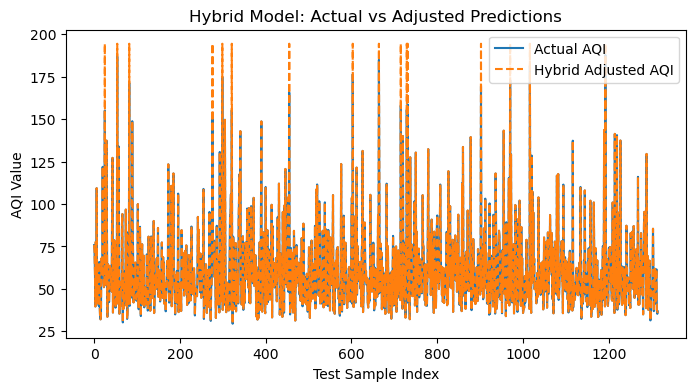

In [82]:
plt.figure(figsize=(8,4))
plt.plot(y_test_pred_best_xgb, label='Actual AQI')
plt.plot(adjusted_prediction, label='Hybrid Adjusted AQI', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('AQI Value')
plt.title('Hybrid Model: Actual vs Adjusted Predictions')
plt.legend()
plt.show()

# Using RFR

In [83]:
adjusted_prediction_rfr=[]

for i in test_best_rfr:
    if i > threshold:
        adjusted_prediction_rfr.append(adjust_prediction(i, y_train, threshold = threshold, prob = p))
    else:
        adjusted_prediction_rfr.append(i)
adjusted_prediction_rfr = np.array(adjusted_prediction_rfr)

In [84]:
# Define some parameters and compare to the base model
rsme_adj = np.sqrt(mean_squared_error(test_best_rfr, adjusted_prediction_rfr))
r2_adj = r2_score(test_best_rfr,adjusted_prediction_rfr)

print("Base RSME\n")
print(f"Best Base RFR RSME (Test): {test_rsme_best_rfr:.2f}")
print(f"Best Base RFR R^2 (Test): {test_r2_best_rfr:.2f}")


print("\nHybrid Random Forest Regressor + Genpareto\n")
print("Hybrid RMSE: ", rsme_adj)
print("Hybrid R2 Test: ", r2_adj)

rsme_hybrid_vs_truth_rfr = np.sqrt(mean_squared_error(y_test, adjusted_prediction_rfr))
r2_hybrid_vs_truth_rfr = r2_score(y_test, adjusted_prediction_rfr)

print("\nHybrid vs Truth")
print("H v T RSME: ", rsme_hybrid_vs_truth_rfr)
print("H v T R2: ", r2_hybrid_vs_truth_rfr)

Base RSME

Best Base RFR RSME (Test): 9.62
Best Base RFR R^2 (Test): 0.86

Hybrid Random Forest Regressor + Genpareto

Hybrid RMSE:  2.707181885193667
Hybrid R2 Test:  0.9872047645511587

Hybrid vs Truth
H v T RSME:  9.901826862597542
H v T R2:  0.8524496413043319


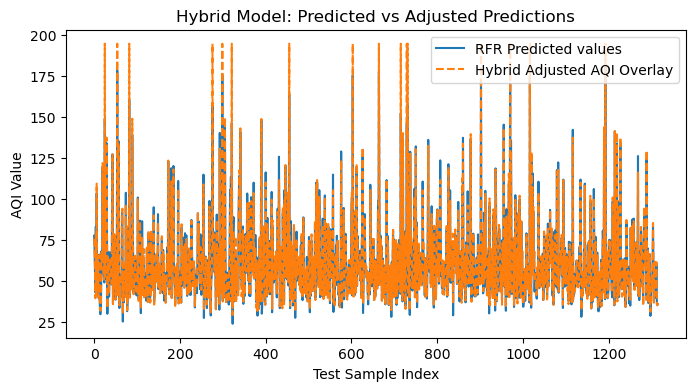

In [85]:
plt.figure(figsize=(8,4))
plt.plot(test_best_rfr, label='RFR Predicted values')
plt.plot(adjusted_prediction, label='Hybrid Adjusted AQI Overlay', linestyle='--')
plt.xlabel('Test Sample Index')
plt.ylabel('AQI Value')
plt.title('Hybrid Model: Predicted vs Adjusted Predictions')
plt.legend()
plt.show()

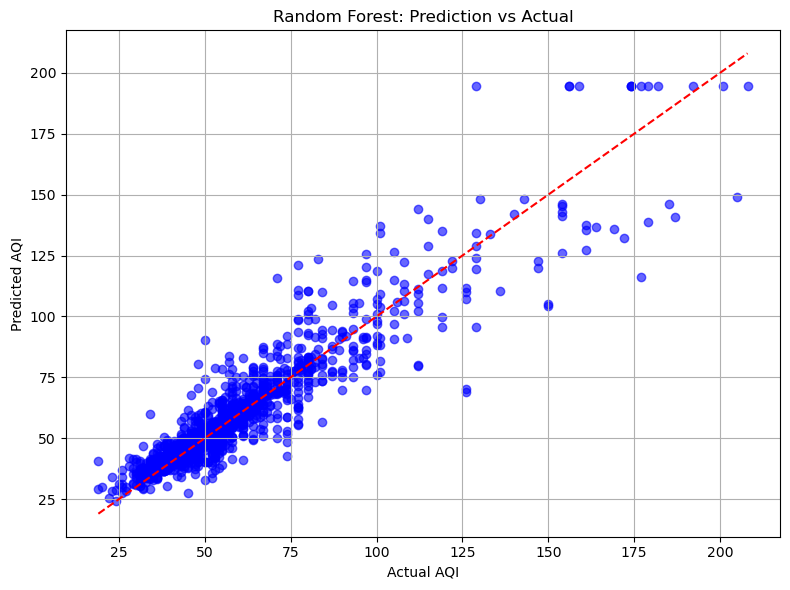

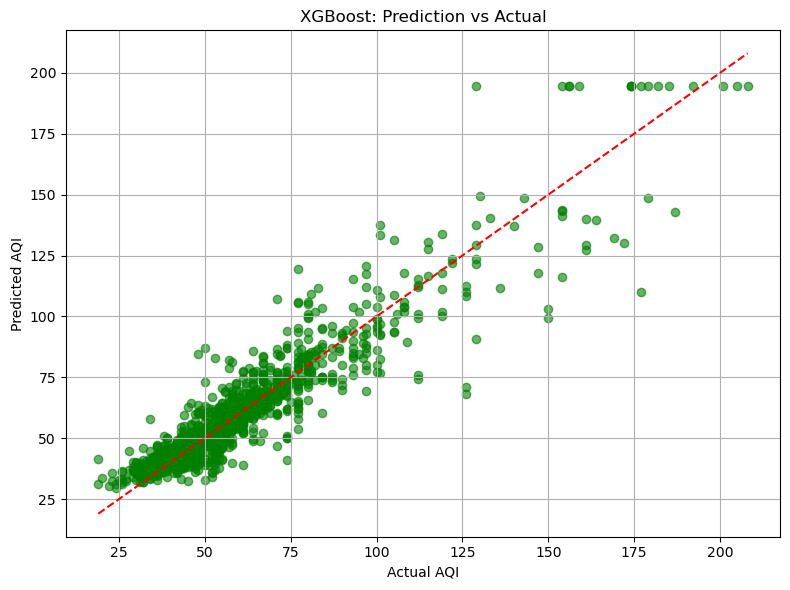

In [86]:
# RFR plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, adjusted_prediction_rfr, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Random Forest: Prediction vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost Regressor
plt.figure(figsize=(8, 6))
plt.scatter(y_test, adjusted_prediction, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("XGBoost: Prediction vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Using LSTM

In [87]:
# Inverse transform all data to original AQI scale ===
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
lstm_y_test_original = scaler_y.inverse_transform(lstm_y_test.reshape(-1, 1)).flatten()

In [88]:
# Define function to compute EVT return level, do this similar to RFR and XGBoost, but adjust for LSTM predictions,
# we try to remove top 5% of values to get return value down but it does not work
def compute_evt_return_level(his_values, threshold, prob):
    exceedances = his_values[his_values > threshold]
    
    if len(exceedances) < 10:
        return None

    # Remove top 1-5% extreme values
    cutoff = np.percentile(exceedances, 90)
    filtered_excess = exceedances[exceedances <= cutoff] - threshold

    shape, loc, scale = genpareto.fit(filtered_excess, floc=0)

    if shape != 0:
        return_level = threshold + (scale / shape) * ((1 - prob) ** (-shape) - 1)
    else:
        return_level = threshold - scale * np.log(1 - prob)

    print(f"Shape: {shape:.3f}, Scale: {scale:.2f}, Return Level: {return_level:.2f}")
    return min(return_level, threshold * 1.5)

In [89]:
# Compute EVT-adjusted value
p = 0.9  # Tail probability for EVT
evt_adjusted_value = compute_evt_return_level(y_train_original, threshold=150, prob=p)

Shape: -1.135, Scale: 19978.98, Return Level: 16458.53


In [90]:
# Apply EVT adjustment to predictions above threshold
adjusted_prediction_lstm = [
    evt_adjusted_value if pred > threshold and evt_adjusted_value is not None else pred
    for pred in y_pred_original
]
adjusted_prediction_lstm = np.array(adjusted_prediction_lstm)

In [91]:
# Print metrics
print("\nBase LSTM Performance (Original AQI Scale)")
rmse_base = np.sqrt(mean_squared_error(lstm_y_test_original, y_pred_original))
r2_base = r2_score(lstm_y_test_original, y_pred_original)
print(f"RMSE: {rmse_base:.2f}")
print(f"R^2:   {r2_base:.2f}")

print("\nHybrid LSTM + GPD Performance")
rmse_hybrid = np.sqrt(mean_squared_error(lstm_y_test_original, adjusted_prediction_lstm))
r2_hybrid = r2_score(lstm_y_test_original, adjusted_prediction_lstm)
print(f"RMSE: {rmse_hybrid:.2f}")
print(f"R^2:   {r2_hybrid:.2f}")


Base LSTM Performance (Original AQI Scale)
RMSE: 8.89
R^2:   0.85

Hybrid LSTM + GPD Performance
RMSE: 10.57
R^2:   0.79


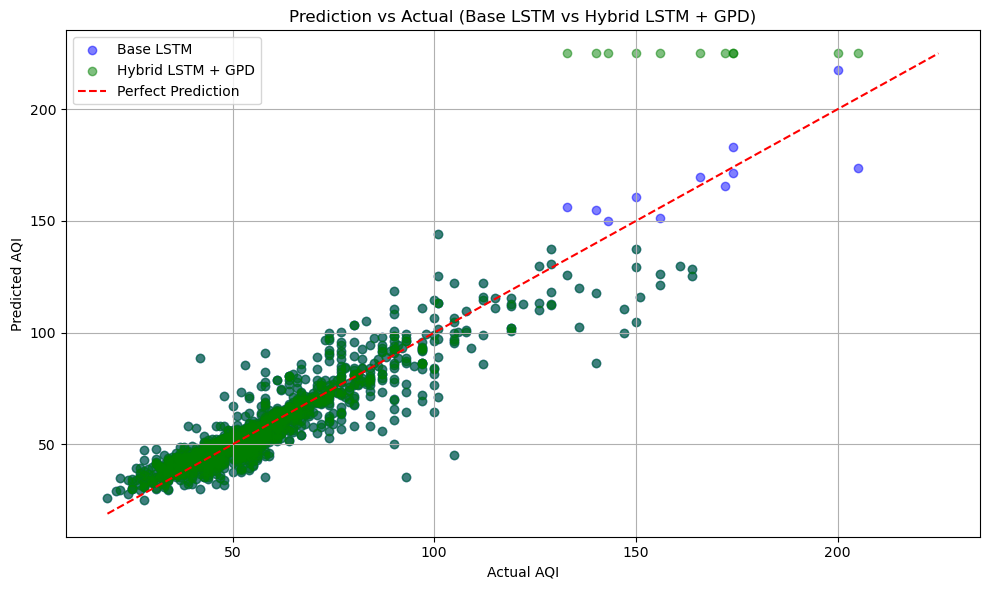

In [92]:
# Plot prediction vs actual
plt.figure(figsize=(10, 6))
plt.scatter(lstm_y_test_original, y_pred_original, alpha=0.5, label="Base LSTM", color="blue")
plt.scatter(lstm_y_test_original, adjusted_prediction_lstm, alpha=0.5, label="Hybrid LSTM + GPD", color="green")
min_val = min(lstm_y_test_original.min(), y_pred_original.min(), adjusted_prediction_lstm.min())
max_val = max(lstm_y_test_original.max(), y_pred_original.max(), adjusted_prediction_lstm.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Prediction vs Actual (Base LSTM vs Hybrid LSTM + GPD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()